### import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

### load data

In [2]:
#TODO: change the path once moved to AWS
df_raw = pd.read_csv('..\data\GlobalLandTemperaturesByCountry.csv', index_col = 'dt', parse_dates = True).sort_index()

In [3]:
#TODO: change the path once moved to AWS
df_co2_raw = pd.read_csv('..\data\CAIT Country CO2 Emissions.csv', index_col = ['Country', 'Year']).sort_index()

### data cleansing and transformation

In [4]:
# subset the temperature data to the countries of interest
df = df_raw[df_raw.Country.isin(['United States', 'China', 'India'])]

In [5]:
# remove any data prior to 1870 because some months are missing temperature data. 
# also, remove data in 2013 as it does not have a full year data. 
START_DT = '1870-01-01'
END_DT = '2012-12-31'
df = df.loc[START_DT:END_DT]

In [6]:
# create a dataframe for Annualized Average Temperature
df_avg_temp_annual = df.groupby('Country') \
    .resample('A') \
    .mean()

In [7]:
# change the second level index from date to year
df_avg_temp_annual['Year'] = df_avg_temp_annual.index.get_level_values('dt').year
df_avg_temp_annual = df_avg_temp_annual \
    .reset_index() \
    .loc[:,['Country', 'Year', 'AverageTemperature']] \
    .set_index(['Country', 'Year'])

In [8]:
# create a dataframe for Moving Average Temperature
df_avg_temp_ma = df.pivot_table(values='AverageTemperature',
              index='dt',
              columns='Country') \
    .rolling(window=12) \
    .mean()

In [9]:
# create a dataframe containing CO2 emission data
df_co2_annual = df_co2_raw \
    .loc[pd.IndexSlice[['United States of America', 'China', 'India'], pd.IndexSlice[1870:2012]], :]

df_co2_annual.rename(index={'United States of America':'United States'},inplace=True)

C:\Users\m187531\AppData\Local\conda\conda\envs\my_root\lib\site-packages\pandas\core\frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


### visualize

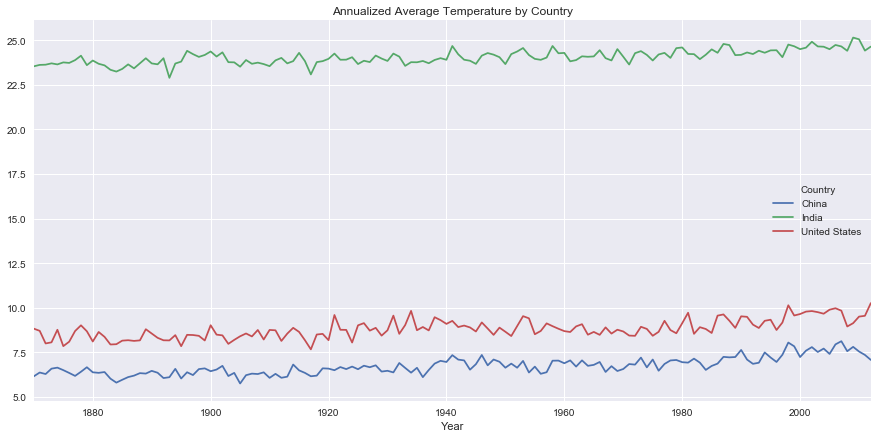

In [12]:
df_avg_temp_annual \
    .pivot_table(values='AverageTemperature',
              index='Year',
              columns='Country') \
    .plot(figsize=(15,7))
plt.title('Annualized Average Temperature by Country');

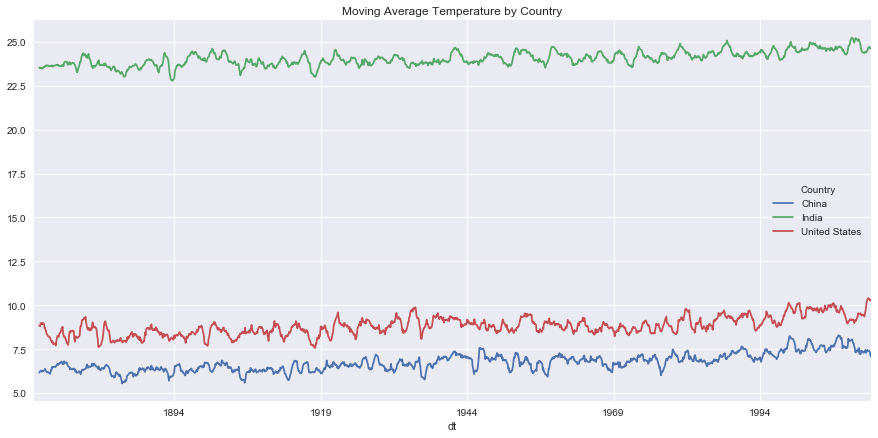

In [13]:
df_avg_temp_ma.plot(figsize=(15,7))
plt.title('Moving Average Temperature by Country');

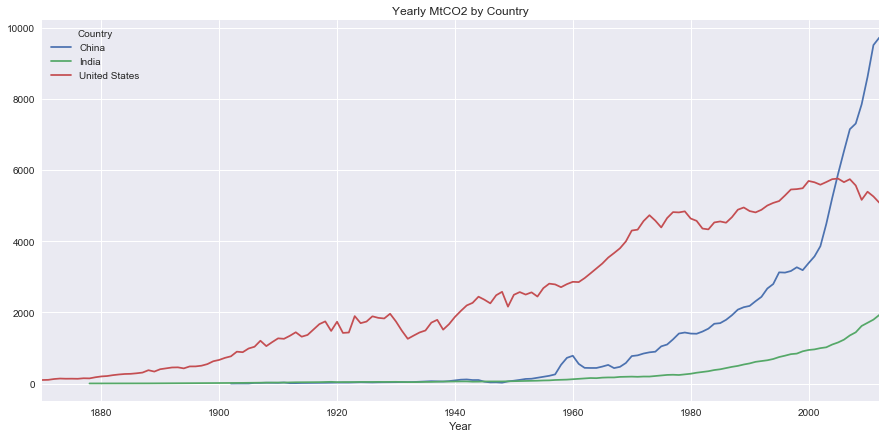

In [11]:
df_co2_annual \
    .pivot_table(values='MtCO2',
                index='Year',
                columns='Country') \
    .plot(figsize=(15,7))
plt.title('Yearly MtCO2 by Country');

In [14]:
# merge temperature and CO2 data
df_temp_co2_comb = df_avg_temp_annual \
    .join(df_co2_annual, how='left')\
    .reset_index()

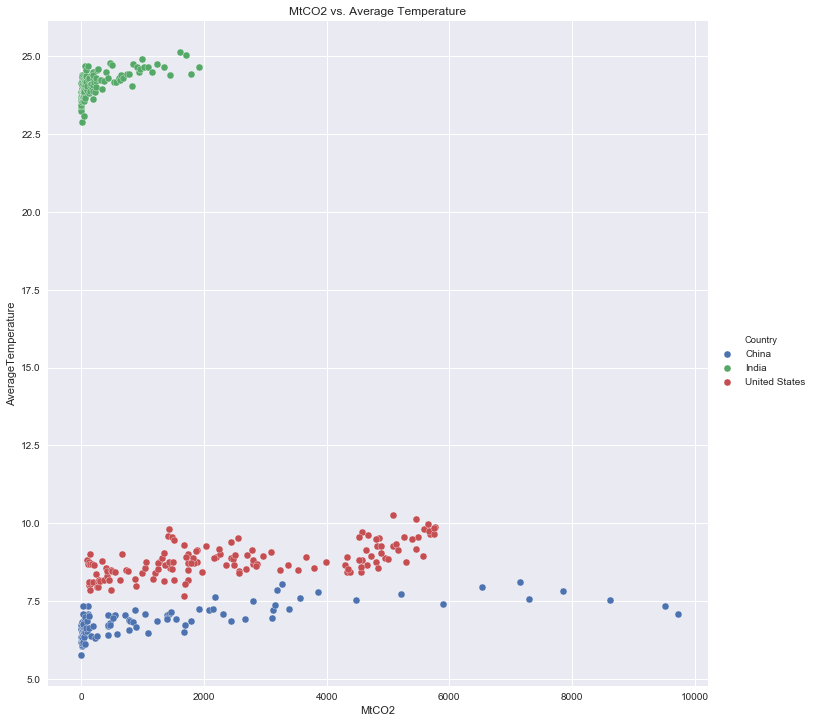

In [15]:
sns.pairplot(x_vars='MtCO2', y_vars='AverageTemperature', data=df_temp_co2_comb, hue='Country', size=10)
plt.title('MtCO2 vs. Average Temperature');

In [16]:
# normalize data
df_temp_co2_normalized_prep = df_temp_co2_comb \
    .groupby('Country') \
    .transform(lambda x: (x - x.mean()) / x.std()) \
    .loc[:, ['AverageTemperature', 'MtCO2']] \
    .rename(columns = {'AverageTemperature': 'Normalized Avg Temp', 'MtCO2': 'Normalized MtCO2'}) 

In [20]:
df_temp_co2_normalized = pd.concat([df_temp_co2_comb, df_temp_co2_normalized_prep], axis=1)

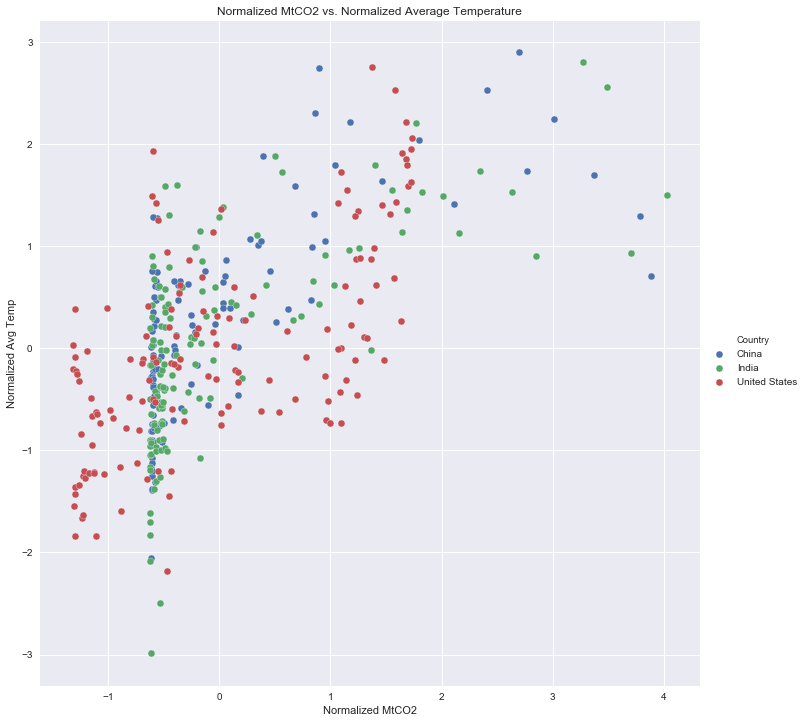

In [23]:
sns.pairplot(x_vars='Normalized MtCO2', y_vars='Normalized Avg Temp', data=df_temp_co2_normalized, hue='Country', size=10)
plt.title('Normalized MtCO2 vs. Normalized Average Temperature');